In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:

import json
import string
import requests
import itertools
from datetime import datetime
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset

from transformers import EvalPrediction
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, hamming_loss

In [3]:
# Specify the file name to read
file_name = 'github_issues.json'

# Read the contents of the JSON file
with open(file_name, 'r') as file:
    issues = json.load(file)

In [4]:
# Extracting data
data = []
labels = []
dates = []
reporters = []

for issue in issues:
    data.append(issue['title'])
    
    if issue['labels']:
        labels.append([label['name'] for label in issue['labels']])
    else:
        labels.append(['unlabeled'])
        
    created_at = datetime.strptime(issue['created_at'], '%Y-%m-%dT%H:%M:%SZ')
    dates.append(created_at)
    
    reporters.append(issue['user']['login'])

In [5]:
dataset = {'issues': data, 'labels': labels, 'dates': dates, 'reporters': reporters}
# Create a pandas DataFrame
df = pd.DataFrame(dataset)
df

,issues,labels,dates,reporters
0,Add missing alias to errors array,[activemodel],2024-02-03 01:01:09,laomatt
1,esbuild precompilation error in rails 7.1.3,[unlabeled],2024-02-02 14:43:34,PhilippGsell
2,Add webp as a default to active_storage.web_im...,"[railties, docs, activestorage]",2024-02-02 12:51:26,lewispb
3,set default_enforce_utf8 to false,[actionview],2024-02-02 11:11:21,ironsand
4,Add class name to enum validation exception me...,[activerecord],2024-02-02 11:07:18,amkisko
...,...,...,...,...
495,ActiveStorage::DiskController fails for upload...,"[attached PR, With reproduction steps, actives...",2024-01-05 14:01:29,alexandergitter
496,Document `upsert`/`upsert_all` `on_duplicate: ...,[activerecord],2024-01-05 13:49:07,lucasmazza
497,Active Storage Variant causing Aws::S3::Errors...,[activestorage],2024-01-04 18:44:36,basiszwo
498,Port `ActiveRecord::AttributeMethods::Query` t...,"[activemodel, activerecord]",2024-01-04 16:07:32,seanpdoyle


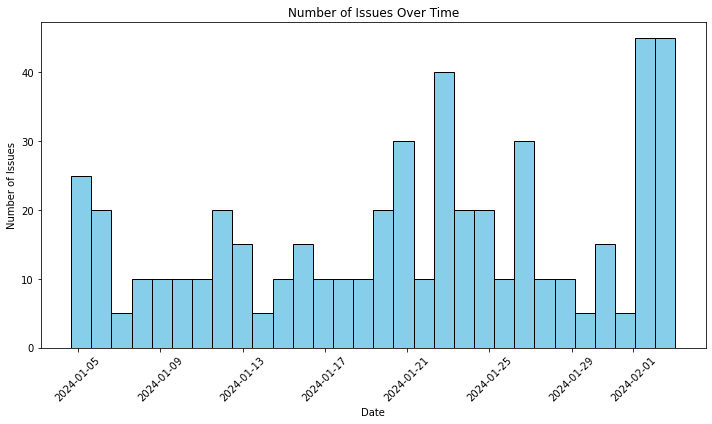

In [6]:
# Plotting the number of issues over time
plt.figure(figsize=(10, 6))
plt.hist(df['dates'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Date')
plt.ylabel('Number of Issues')
plt.title('Number of Issues Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
reporter_counts = [reporter for reporter in df['reporters']]
pd.Series(reporter_counts).value_counts()

seanpdoyle         30
joshuay03          15
djmb               15
casperisfine       15
fatkodima          15
                   ..
tgxworld            5
gagalago            5
tsvallender         5
Takahashi-Seiji     5
basiszwo            5
Length: 81, dtype: int64

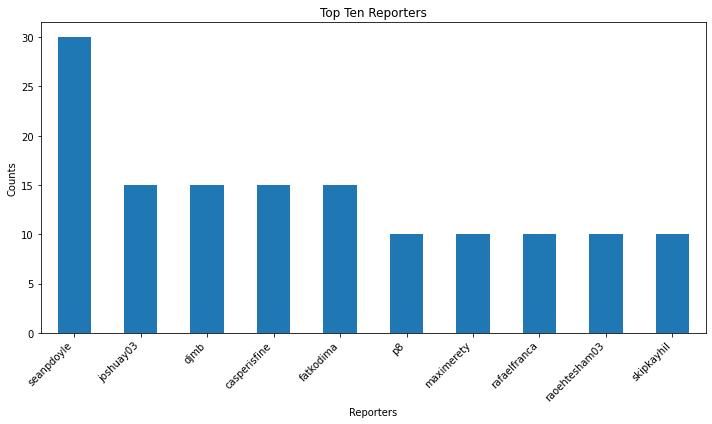

In [8]:
reporter_counts = df['reporters'].value_counts()

# Selecting the top ten counts
top_ten_reporters = reporter_counts.head(10)

# Plotting the top ten counts
plt.figure(figsize=(10, 6))
top_ten_reporters.plot(kind='bar')
plt.title('Top Ten Reporters')
plt.xlabel('Reporters')
plt.ylabel('Counts')
plt.xticks(rotation=45, ha='right')  # Rotate x-labels for better readability
plt.tight_layout()
plt.show()

In [9]:
label_list = list(itertools.chain.from_iterable(df['labels']))
pd.Series(label_list).value_counts()

activerecord               200
railties                    75
unlabeled                   60
activestorage               60
docs                        50
actionview                  45
actionpack                  30
activesupport               25
With reproduction steps     25
attached PR                 20
activemodel                 15
more-information-needed     10
actionmailbox               10
actiontext                  10
actionmailer                10
ci issues                    5
dtype: int64

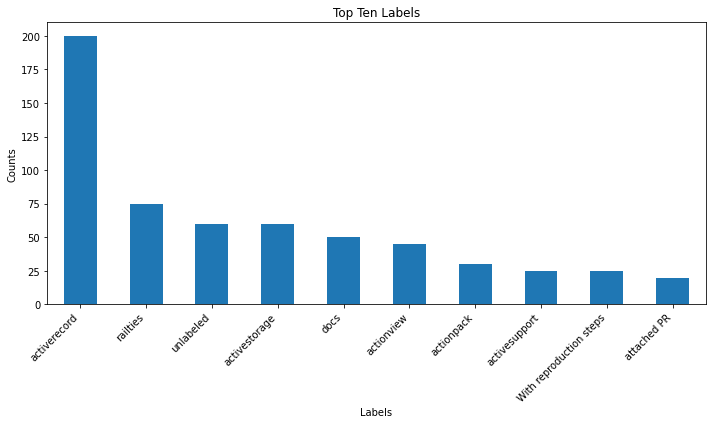

In [10]:
label_counts = pd.Series(label_list).value_counts()

# Selecting the top ten counts
top_ten_labels = label_counts.head(10)

# Plotting the top ten counts
plt.figure(figsize=(10, 6))
top_ten_labels.plot(kind='bar')
plt.title('Top Ten Labels')
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.xticks(rotation=45, ha='right')  # Rotate x-labels for better readability
plt.tight_layout()
plt.show()

In [11]:
multilabel = MultiLabelBinarizer()
labels = multilabel.fit_transform(df['labels']).astype('float32')
labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [12]:
issues = df['issues'].tolist()

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(issues, labels, test_size=0.2, random_state=42)

In [13]:
checkpoint = "bert-base-uncased"

# Load the pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained(checkpoint)
# Define the model
model = BertForSequenceClassification.from_pretrained(checkpoint, num_labels=len(labels[0]))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# Lets build custom dataset
class CustomDataset(Dataset):
    def __init__(self, issues, labels, tokenizer, max_token_len=128):
        self.issues = issues
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len

    def __len__(self):
        return len(self.issues)

    def __getitem__(self, idx):
        issues = str(self.issues[idx])
        labels = torch.tensor(self.labels[idx])

        encoding = self.tokenizer(
            issues, 
            truncation=True,
            padding="max_length",
            max_length=self.max_token_len,
            return_tensors='pt')


        return {
            'input_ids': np.array(encoding['input_ids']).flatten(),
            'attention_mask': np.array(encoding['attention_mask']).flatten(),
            'labels': labels
        }

In [15]:
train_dataset = CustomDataset(X_train, y_train, tokenizer)
test_dataset = CustomDataset(X_test, y_test, tokenizer)

In [16]:
# Multi-Label Classification Evaluation Metrics
def multi_labels_metrics(predictions, labels, threshold=0.3):
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))

    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs>=threshold)] = 1
    y_true = labels

    f1 = f1_score(y_true, y_pred, average = 'macro')
    hamming = hamming_loss(y_true, y_pred)

    metrics = {
      "hamming_loss": hamming,
      "f1": f1
    }

    return metrics

def compute_metrics(p:EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    result = multi_labels_metrics(predictions=preds, labels=p.label_ids)
    return result

In [17]:
# Training Arguments
args = TrainingArguments(
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    output_dir = './results',
    num_train_epochs=50,
    save_steps=1000,
    save_total_limit=2
)

trainer = Trainer(model=model,
                  args=args,
                  train_dataset=train_dataset,
                  eval_dataset=test_dataset,
                  compute_metrics=compute_metrics)

In [18]:
trainer.train()

Step,Training Loss
500,0.123100
1000,0.020700
1500,0.010600
2000,0.007400
2500,0.006200


TrainOutput(global_step=2500, training_loss=0.033610311317443846, metrics={'train_runtime': 14244.0719, 'train_samples_per_second': 1.404, 'train_steps_per_second': 0.176, 'total_flos': 1315720642560000.0, 'train_loss': 0.033610311317443846, 'epoch': 50.0})

In [19]:
trainer.evaluate()

{'eval_loss': 0.00713806226849556,
 'eval_hamming_loss': 0.0,
 'eval_f1': 0.9375,
 'eval_runtime': 22.5506,
 'eval_samples_per_second': 4.434,
 'eval_steps_per_second': 0.576,
 'epoch': 50.0}

In [20]:
def model_prediction(issue):
    encoding = tokenizer(issue, return_tensors='pt')
    encoding.to(trainer.model.device)

    outputs = trainer.model(**encoding)
    
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(outputs.logits[0].cpu())
    preds = np.zeros(probs.shape)
    preds[np.where(probs>=0.3)] = 1
    
    return list(multilabel.inverse_transform(preds.reshape(1,-1))[0])

In [21]:
sample_data = df[['issues', 'labels']].head(10)

predictons = []
for issue in sample_data['issues']:
    predict = model_prediction(issue)
    predictons.append(predict)
sample_data.rename(columns={'labels': 'true labels'}, inplace=True)
sample_data['predicted labels'] = predictons
sample_data

,issues,true labels,predicted labels
0,Add missing alias to errors array,[activemodel],[activemodel]
1,esbuild precompilation error in rails 7.1.3,[unlabeled],[unlabeled]
2,Add webp as a default to active_storage.web_im...,"[railties, docs, activestorage]","[activestorage, docs, railties]"
3,set default_enforce_utf8 to false,[actionview],[actionview]
4,Add class name to enum validation exception me...,[activerecord],[activerecord]
5,Add a Rails Guide for tuning performance for d...,[docs],[docs]
6,Destroying bi-directional has_one through asso...,[unlabeled],[unlabeled]
7,ActiveStorage::IntegrityError (ActiveStorage::...,[unlabeled],[unlabeled]
8,Fix error raised when running `db:schema:load:...,"[activerecord, railties]","[activerecord, railties]"
9,Introduce today_or_future? method,[activesupport],[activesupport]
